<a href="https://colab.research.google.com/github/s-pike3/Projects_In_AI-ML/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projects in AI & ML HW3 \\
Sarah Pike


Link to the dataset: https://www.kaggle.com/competitions/playground-series-s3e11/data

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler  # for feature scaling
from sklearn.model_selection import train_test_split  # for train/test split
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import GridSearchCV
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import math
import torch
from torch import nn
from torch.nn import functional as F
!pip install skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from skorch.dataset import Dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 4.2 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
# Load data
df = pd.read_csv("train.csv")
df.head()
len(df)

360336

In [ ]:
#Split target variable from features
X1 = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [ ]:
y.head()

,cost
0,62.09
1,121.80
2,83.51
3,66.78
4,111.51


In [ ]:
X1.drop(['id'], axis=1, inplace=True)

#### EDA

Distribution of Each Feature

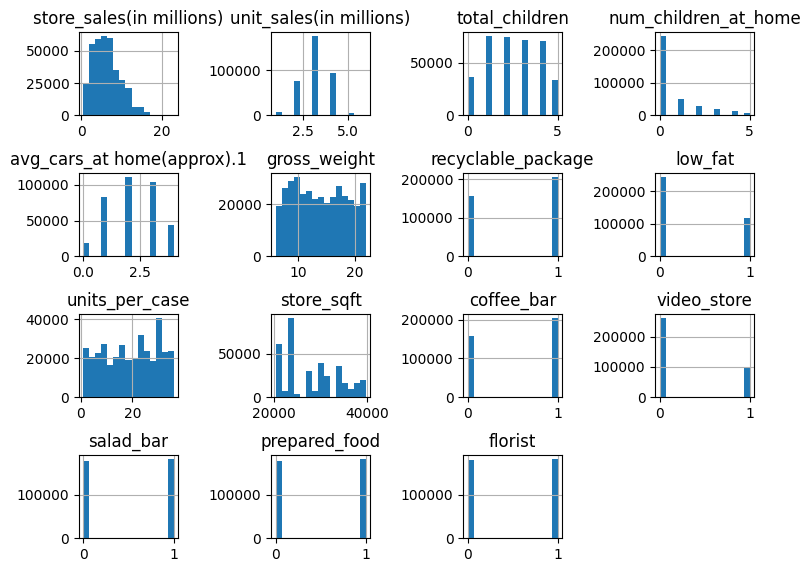

In [ ]:
hist = X1.hist(bins=15)
plt.rcParams.update({'font.size': 8})
plt.tight_layout(rect=(0, 0, 1.2, 1.2))
plt.show()

### Pre-processing

In [ ]:
from sklearn.model_selection import train_test_split
#split into training and test set
X_train, X_temp, y_train, y_temp = train_test_split(X1, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)
#convert to numpy
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

#check shapes
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((288268, 15), (36034, 15), (36034, 15), (288268,), (36034,), (36034,))

In [ ]:
#unscaled feature data
X_train_ns = X_train
X_val_ns = X_val
X_test_ns = X_test

In [ ]:
#scale feature data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

### Neural Network from Scratch


In [ ]:
# Adapted from https://medium.com/towards-data-science/math-neural-network-from-scratch-in-python-d6da9f29ce65
#Create base layer class which linear layer and activiation layer will inherit from
class Layer():
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, X):
        raise NotImplementedError

    def backward(self, loss, lr):
        raise NotImplementedError

#Class for single linear layer of neural network
class LinearLayer(Layer):
  def __init__(self, in_size, out_size):
    self.w = np.random.rand(in_size,out_size)
    self.b = np.random.rand(1,out_size)

  def forward(self, X):
      self.input = X
      return np.dot(X,self.w) + self.b

  def backward(self, output_err, lr):
      dw = np.dot(self.input.T.reshape(-1,1), output_err)
      input_err = np.dot(output_err, self.w.T)

      self.w -= lr * dw
      self.b -= lr * output_err
      return input_err

#Activation class for neural network
#Uses reLu as activation function
class ActivationLayer(Layer):
  def __init__(self):
    self.input = None

  def forward(self, X):
      self.input = X
      return relu(X)

  def backward(self, output_err, lr):
      return d_relu(self.input) * output_err




In [ ]:
#Source: https://github.com/xbeat/Machine-Learning/blob/main/Building%20a%20ReLU%20Activation%20Function%20from%20Scratch%20in%20Python.md
def d_relu(x):
    return np.where(x > 0, 1, 0)

def relu(x):
    return np.maximum(0, x)

In [ ]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [ ]:
#Neural network class
class NeuralNetwork():
  def __init__(self):
    self.loss = 0
    #store list of layers
    self.layers = []

  #add layers to network
  def add(self, layer):
    self.layers.append(layer)

  def forwards(self, X):
    #run forwards propagation through each layer
    for i in range(len(self.layers)):
      X = self.layers[i].forward(X)
    return X

  def backwards(self,loss,lr):
    #run backwards propagation through each layer
      n_layers = len(self.layers)
      for i in range(len(self.layers)):
        loss = self.layers[n_layers - 1 - i].backward(loss,lr)
      return loss

  def train(self, X_train, y_train,n_epochs, lr):
    #run n_epochs iterations of stocastic gradient descent
    for i in range(n_epochs):
      j = np.random.randint(0,len(X_train))
      y_pred = self.forwards(X_train[j])
      loss = mse_prime(y_train[j],y_pred)
      self.backwards(loss,lr)
      print("epoch ", i, " , loss ", loss)


  def predict(self, input_data):
        num_samples = len(input_data)
        result = []
        # run network over all samples
        for i in range(num_samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward(output)
            result.append(output)
        return result

  def cost(self,y_true,y_pred):
    return mse(y_true,y_pred)



In [ ]:
#2 layer neural network with reLu activation functions
net = NeuralNetwork()
net.add(LinearLayer(15, 8))
net.add(ActivationLayer())
net.add(LinearLayer(8, 8))
net.add(ActivationLayer())
net.add(LinearLayer(8, 1))

# train
net.train(X_train, y_train, 5000, 0.01)

# test
out = net.forwards(X_test)


epoch  0  , loss  [[-254.17256155]]
epoch  1  , loss  [[357.27983824]]
epoch  2  , loss  [[-234.68999596]]
epoch  3  , loss  [[-287.33619604]]
epoch  4  , loss  [[-202.96947212]]
epoch  5  , loss  [[-132.75008268]]
epoch  6  , loss  [[-165.35508103]]
epoch  7  , loss  [[-211.24797941]]
epoch  8  , loss  [[-230.90301982]]
epoch  9  , loss  [[-235.06495942]]
epoch  10  , loss  [[-226.20366023]]
epoch  11  , loss  [[-92.35958703]]
epoch  12  , loss  [[-165.77239529]]
epoch  13  , loss  [[-210.75694738]]
epoch  14  , loss  [[-73.02180844]]
epoch  15  , loss  [[-59.48137227]]
epoch  16  , loss  [[-135.79174482]]
epoch  17  , loss  [[-87.19590992]]
epoch  18  , loss  [[-136.61199173]]
epoch  19  , loss  [[-231.81975189]]
epoch  20  , loss  [[-121.98335685]]
epoch  21  , loss  [[-99.96368972]]
epoch  22  , loss  [[-107.96441592]]
epoch  23  , loss  [[-130.9851276]]
epoch  24  , loss  [[-31.84542505]]
epoch  25  , loss  [[-97.28851655]]
epoch  26  , loss  [[-208.16274622]]
epoch  27  , loss  [

In [ ]:
out.shape

(36034, 1)

In [ ]:
from sklearn.metrics import root_mean_squared_log_error
msle = root_mean_squared_log_error(y_test, out)
print(f'RMSLE: {msle:.4f}')

MSLE: 0.3195


I implemented a multi-layer neural network with reLu activation functions. I choose to use stochastic gradient descent because it is fast and enables me to get a similar loss to the neural network implemented with PyTorch.

Aflak, O. (2021, May 24). Neural network from scratch in Python. Medium. https://medium.com/towards-data-science/math-neural-network-from-scratch-in-python-d6da9f29ce65

Xbeat. (n.d.). Machine-learning/building a relu activation function from scratch in Python.md at main · xbeat/machine-learning. GitHub. https://github.com/xbeat/Machine-Learning/blob/main/Building%20a%20ReLU%20Activation%20Function%20from%20Scratch%20in%20Python.md

### Pytorch Implementation


#### Task 1
I was previously familiar with PyTorch. Sources I used to implement this model are cited below. Using a library such as PyTorch is beneficial because the code is more highly optimized, which allows for greater model complexity and faster computation. Since the library provides many methods that are already implemented, it is easier to experiement with different model architectures and optimizers.

Coelho, C. R. (2023, November 28). Logistic regression-pytorch. Medium. https://medium.com/@carlosrodrigo.coelho/logistic-regression-pytorch-956f96b28010

Zhang, A., Lipton, Z., Li, M., & Smola, A. (2023). Dive into Deep Learning. Cambridge University Press.

In [ ]:
#Prepare data for training
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

In [ ]:
X_train_ns = torch.from_numpy(X_train_ns.astype(np.float32))
X_test_ns = torch.from_numpy(X_test_ns.astype(np.float32))

In [ ]:
#dive into deep learning
class NN2(nn.Module):
  #2 layer model with hidden layer size 8
  #ReLU activiation functions for both layers
    def __init__(self,layer_size):
        super().__init__()
        self.net = nn.Sequential(nn.LazyLinear(layer_size), nn.ReLU(),
                                 nn.LazyLinear(layer_size), nn.ReLU())
        self.linear = nn.LazyLinear(1)

    def forward(self, X):
        return self.linear(self.net(X))

#### Baseline results

In [ ]:
model = NN2(8)
learning_rate = 0.05
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 3000

for epoch in range(num_epochs):
    # forward pass and loss
    y_predicted = model.forward(X_train)
    loss = criterion(y_predicted, y_train)

    # backward pass
    loss.backward()

    # updates
    optimizer.step()

    # zero gradients
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 10, loss = 8652.2441
epoch: 20, loss = 1955.3708
epoch: 30, loss = 1244.7308
epoch: 40, loss = 1211.1155
epoch: 50, loss = 1075.5200
epoch: 60, loss = 1004.1425
epoch: 70, loss = 961.6405
epoch: 80, loss = 937.3992
epoch: 90, loss = 922.6198
epoch: 100, loss = 912.8857
epoch: 110, loss = 906.2600
epoch: 120, loss = 901.5428
epoch: 130, loss = 897.8166
epoch: 140, loss = 894.6829
epoch: 150, loss = 891.9270
epoch: 160, loss = 889.4388
epoch: 170, loss = 887.1459
epoch: 180, loss = 885.0369
epoch: 190, loss = 883.1306
epoch: 200, loss = 881.4199
epoch: 210, loss = 879.8999
epoch: 220, loss = 878.5486
epoch: 230, loss = 877.3440
epoch: 240, loss = 876.2780
epoch: 250, loss = 875.3345
epoch: 260, loss = 874.4926
epoch: 270, loss = 873.7477
epoch: 280, loss = 873.0775
epoch: 290, loss = 872.4753
epoch: 300, loss = 871.9360
epoch: 310, loss = 871.4411
epoch: 320, loss = 870.9775
epoch: 330, loss = 870.5397
epoch: 340, loss = 870.1310
epoch: 350, loss = 869.7446
epoch: 360, loss = 869.

In [ ]:
from sklearn.metrics import root_mean_squared_log_error
y_pred = model.forward(X_test).detach().numpy()
msle = root_mean_squared_log_error(y_test, y_pred)
print(f'RMSLE: {msle:.4f}')

RMSLE: 0.3142


I implemented a 2 layer network with relu activation functions. I chose Adam as my optimization function. This model acheives a 0.3142 RMSLE which is roughly the same as the RMSLE of 0.3195 from the network implemented from scratch.

### Non- normalized inputs

In [ ]:
num_epochs = 3000

for epoch in range(num_epochs):
    # forward pass and loss
    y_predicted = model.forward(X_train_ns)
    loss = criterion(y_predicted, y_train)

    # backward pass
    loss.backward()

    # updates
    optimizer.step()

    # zero gradients
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 10, loss = 10799.7520
epoch: 20, loss = 10944.3662
epoch: 30, loss = 10993.6875
epoch: 40, loss = 11010.6885
epoch: 50, loss = 11016.3340
epoch: 60, loss = 11017.9922
epoch: 70, loss = 11018.2539
epoch: 80, loss = 11018.0225
epoch: 90, loss = 11017.6182
epoch: 100, loss = 11017.1484
epoch: 110, loss = 11016.6572
epoch: 120, loss = 11016.1562
epoch: 130, loss = 11015.6484
epoch: 140, loss = 11015.1377
epoch: 150, loss = 11014.6230
epoch: 160, loss = 11014.1074
epoch: 170, loss = 11013.5869
epoch: 180, loss = 11013.0654
epoch: 190, loss = 11012.5420
epoch: 200, loss = 11012.0127
epoch: 210, loss = 11011.4834
epoch: 220, loss = 11010.9502
epoch: 230, loss = 11010.4150
epoch: 240, loss = 11009.8770
epoch: 250, loss = 11009.3350
epoch: 260, loss = 11008.7910
epoch: 270, loss = 11008.2432
epoch: 280, loss = 11007.6943
epoch: 290, loss = 11007.1426
epoch: 300, loss = 11006.5869
epoch: 310, loss = 11006.0273
epoch: 320, loss = 11005.4678
epoch: 330, loss = 11004.9043
epoch: 340, loss = 

In [ ]:
from sklearn.metrics import root_mean_squared_log_error
y_pred = model.forward(X_test_ns).detach().numpy()
msle = root_mean_squared_log_error(y_test, y_pred)
print(f'RMSLE: {msle:.4f}')

RMSLE: 4.0628


RMSLE is 4.0628 when putting in non-normalized inputs into the model compared with 0.3142 when inputting normalized inputs. Thus, normalizing the input data is essential for this model.

#### Hyperparameter tuning

In [ ]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32).reshape(-1,1)
y_test = y_test.astype(np.float32).reshape(-1,1)

In [ ]:
model = NeuralNetClassifier(
    train_split=None,
    module = NN2,
    criterion = nn.MSELoss,
    optimizer = torch.optim.AdamW,
    optimizer__lr=0.05

)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'optimizer__lr': [0.05, 0.01, 0.001],
    'optimizer__weight_decay' : [0,0.001,0.01],
    'module__layer_size': [8, 16, 32]
}
#Grid search for optimal learning rate
gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='r2')
gs.fit(X_train, y_train)

# Evaluate on test data
print(gs.best_params_)
y_pred = gs.predict(X_test)

  epoch    train_loss     dur
-------  ------------  ------
      1      996.2071  6.9286
      2      889.7752  3.5743
      3      882.4560  3.5705
      4      877.3146  4.5791
      5      874.7508  3.6015
      6      872.9738  3.6204
      7      871.5638  4.0165
      8      868.5389  4.3825
      9      863.7625  3.5540
     10      862.0182  3.6126
  epoch    train_loss     dur
-------  ------------  ------
      1      996.8022  4.5344
      2      893.2187  3.6120
      3      884.2053  3.5858
      4      879.5339  4.8267
      5      876.9944  3.5906
      6      874.9036  3.5532
      7      873.2103  4.1575
      8      872.3431  4.3141
      9      871.5533  3.6357
     10      870.9702  4.4087
  epoch    train_loss     dur
-------  ------------  ------
      1      998.2103  3.8969
      2      882.8169  3.7223
      3      879.3857  4.0900
      4      876.8391  4.5453
      5      874.5508  3.7314
      6      872.1358  3.7478
      7      870.7468  4.7694
      8   

In [ ]:
from sklearn.metrics import root_mean_squared_log_error
y_pred = model.forward(X_test).detach().numpy()
yp = np.array([])
for i in range(len(y_pred)):
  yp = np.append(yp,np.mean(y_pred[i]))
y_test = y_test.reshape(-1)
msle = root_mean_squared_log_error(y_test, yp)
print(f'MSLE: {msle:.4f}')


MSLE: 0.3237


I used the skorch wrapper for PyTorch which enabled me to use the sklearn grid search cv method to choose my hyperparameters. The results of this method were that the optimal layer size is 8, the optimal learning rate is 0.05, and the optimal weight decay is 0. Thus, the final method did not use regularization since the best parameter value for weight decay was 0.